In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import EGTtools as egt

import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
egt.Random.init()
seed = egt.Random.seed_

In [3]:
# Payoff matrix
V = 2; D = 3; T = 1
A = np.array([
        [ (V-D)/2, V],
        [ 0      , (V/2) - T],
    ])

In [4]:
game = egt.NormalFormGame(1, A)

In [15]:
Z = 100
x = np.arange(0, Z+1)/Z

In [16]:
evolver = egt.PairwiseMoran(Z, game, 1000000)

In [17]:
Z = 100
x = np.arange(0, Z+1)/Z
evolver.pop_size = Z

In [20]:
dist = evolver.stationary_distribution(10, 100000, 1000, 1, 1e-3)

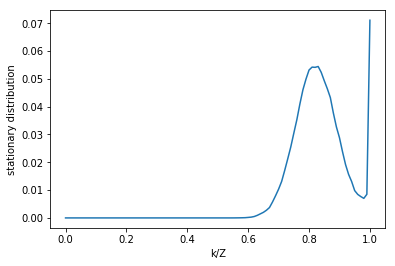

In [21]:
# We need to reverse, since in this case we are starting from the case
# where the number of Haws is 100%, because of how we map states
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, list(reversed(dist)))
ax.set_ylabel('stationary distribution')
ax.set_xlabel('k/Z')
plt.show()

### We can also plot a single run

In [10]:
output = evolver.run(100000, 1, 1e-2, [0, 50])

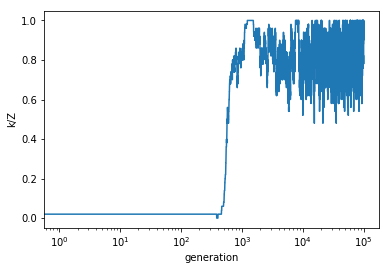

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(output[:, 0]/Z)
ax.set_ylabel('k/Z')
ax.set_xlabel('generation')
ax.set_xscale('log')
plt.show()